In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from efficientnet_pytorch import EfficientNet
import os
from skimage import img_as_ubyte
from skimage.feature import graycomatrix, graycoprops
from torchvision.io import read_image
import torchvision.transforms as transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Creating Custom DataSet

In [35]:
class CellImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.labels = []
        self.haralick_descriptors = []
        self.image_paths = []
        self.transform = transform
        self.class_to_idx = {}

        for idx, class_name in enumerate(os.listdir(img_dir)):
            self.class_to_idx[class_name] = idx
            class_dir = os.path.join(img_dir, class_name)
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_name)
                    haralick_desc = self.calculate_haralick_descriptors(img_path)
                    self.haralick_descriptors.append(haralick_desc)
                    self.labels.append(idx)
                    self.image_paths.append(img_path)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        haralick_desc = self.haralick_descriptors[idx]
        label = self.labels[idx]
        image = read_image(self.image_paths[idx])
        image = transforms.ToPILImage()(image)  # Convert the tensor image to a PIL Image
        if self.transform:
            image = self.transform(image)
        return haralick_desc, image, label

    def calculate_haralick_descriptors(self, img_path):
        image = read_image(img_path)
        gray_image = image.float().mean(dim=0)
        gray_image = (gray_image - gray_image.min()) / (gray_image.max() - gray_image.min())
        gray_image = img_as_ubyte(gray_image)
        co_matrix = graycomatrix(gray_image, distances=[1], angles=[0], levels=256, symmetric=True)
        contrast = graycoprops(co_matrix, prop='contrast')[0, 0]
        dissimilarity = graycoprops(co_matrix, prop='dissimilarity')[0, 0]
        homogeneity = graycoprops(co_matrix, prop='homogeneity')[0, 0]
        energy = graycoprops(co_matrix, prop='energy')[0, 0]
        correlation = graycoprops(co_matrix, prop='correlation')[0, 0]
        asm = graycoprops(co_matrix, prop='ASM')[0, 0]
        haralick_desc = torch.tensor([contrast, dissimilarity, homogeneity, energy, correlation, asm], dtype=torch.float32)
        return haralick_desc

# Adapting EficiNet to the Custom DataSet

In [36]:
class HaralickNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(HaralickNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return x

class EfficientNetHaralickCombined(nn.Module):
    def __init__(self, haralick_input_dim, hidden_dim, haralick_output_dim, num_classes):
        super(EfficientNetHaralickCombined, self).__init__()
        self.efficient_net = EfficientNet.from_pretrained('efficientnet-b0')
        self.haralick_net = HaralickNetwork(haralick_input_dim, hidden_dim, haralick_output_dim)

        # Get the output dimension of the EfficientNet feature extractor
        efficient_net_output_dim = self.efficient_net._fc.in_features
        self.efficient_net._fc = nn.Identity()  # Remove the final classification layer

        # Define the combined fully connected layer
        self.fc_combined = nn.Linear(efficient_net_output_dim + haralick_output_dim, num_classes)

    def forward(self, haralick_features, images):
        haralick_out = self.haralick_net(haralick_features)
        efficient_net_out = self.efficient_net(images)
        efficient_net_out = torch.flatten(efficient_net_out, 1)
        combined_out = torch.cat((efficient_net_out, haralick_out), dim=1)
        out = self.fc_combined(combined_out)
        return out

In [37]:
def evaluate_model(model, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for haralick_desc, images, labels in data_loader:
            outputs = model(haralick_desc, images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    avg_loss = running_loss / len(data_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return avg_loss, accuracy, precision, recall, f1, all_labels, all_preds

def plot_confusion_matrix(true_labels, pred_labels, classes):
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [41]:
img_dir = 'partial_sub_images'
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
dataset = CellImageDataset(img_dir, transform=transform)

train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

input_dim = len(dataset[0][0])
hidden_dim = 128
haralick_output_dim = 64
num_classes = len(dataset.class_to_idx)

model = EfficientNetHaralickCombined(input_dim, hidden_dim, haralick_output_dim, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



Loaded pretrained weights for efficientnet-b0


# Treinamento do modelo

In [42]:

for epoch in range(10):
    model.train()
    running_loss = 0.0
    for haralick_desc, images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(haralick_desc, images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1} - Loss: {running_loss/len(train_loader)}")



Epoch 1 - Loss: 2.3855717976888022
Epoch 2 - Loss: 1.315194050470988
Epoch 3 - Loss: 0.7926331559816996
Epoch 4 - Loss: 0.34570928414662677
Epoch 5 - Loss: 0.27536572019259137
Epoch 6 - Loss: 0.14050022015968958
Epoch 7 - Loss: 0.15652931233247122
Epoch 8 - Loss: 0.0634647086262703
Epoch 9 - Loss: 0.03012461867183447
Epoch 10 - Loss: 0.1618485925719142


# Avaliação do modelo

c:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 4.1437
Test Accuracy: 0.2000
Test Precision: 0.0400
Test Recall: 0.2000
Test F1 Score: 0.0667


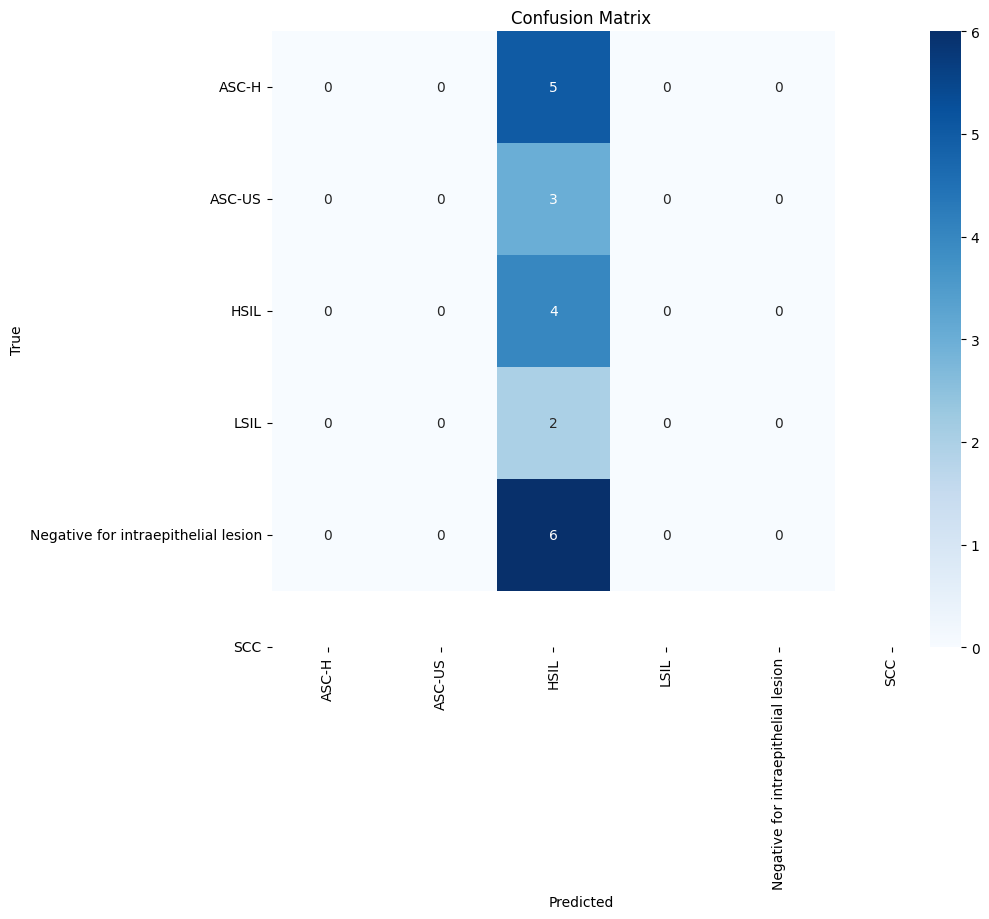

In [43]:
test_loss, test_accuracy, test_precision, test_recall, test_f1, all_labels, all_preds = evaluate_model(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# Plot da matriz de confusão
plot_confusion_matrix(all_labels, all_preds, list(dataset.class_to_idx.keys()))